In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import torch

In [5]:
from bgtorch.distribution import NormalDistribution
from bgtorch.nn.training import KLTrainer
from bgtorch.nn.flow.stochastic import MetropolisMCFlow

In [6]:
from snf_code import prepare_image, ImageEnergy, ImageSampler, sample_bg_histogram
from snf_code.imagetools import boltzmann_generator_RNVP_MC, boltzmann_generator_NSF_MC, kldiv

Prepare data
-----

In [7]:
from snf_code import prepare_image, ImageEnergy, ImageSampler

In [8]:
# Select your image here
#img=mpimg.imread('./data/smiley.jpg')
#img_density, img_energy = prepare_image(img, embed=(1000, 1000), #crop=(10, 710, 240, 940), 
#                                        white_cutoff=225, gauss_sigma=3, background=0.01)
#mean = [500, 500]
#scale = [200, 200]
#tail = 2.5

In [9]:
img=mpimg.imread('./data/labrador.jpg')
img_density, img_energy = prepare_image(img, crop=(10, 710, 240, 940), 
                                        white_cutoff=225, gauss_sigma=3, background=0.01)
mean = [350, 350]
scale = [100, 100]
tail = 3.5

In [10]:
#img=mpimg.imread('./data/vision_test.jpg')
#img_density, img_energy = prepare_image(img, white_cutoff=225, gauss_sigma=2, background=0.01)
#mean = [350, 300]
#scale = [100, 100]
#tail = 3.5

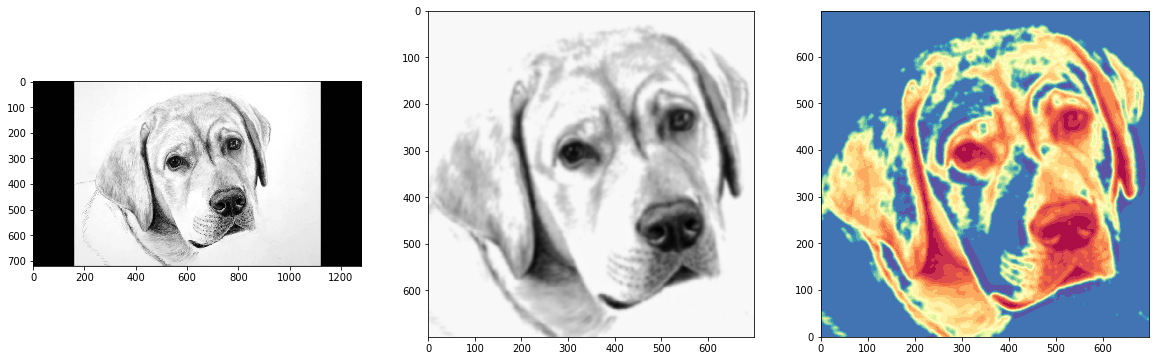

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
axes[0].imshow(img)
axes[1].imshow(img_density, vmin=0, vmax=1, cmap='gray_r')
axes[2].contourf(img_energy[::-1], 20, vmin=img_energy.min(), vmax=img_energy.max(), cmap='Spectral')

Training and energy
----

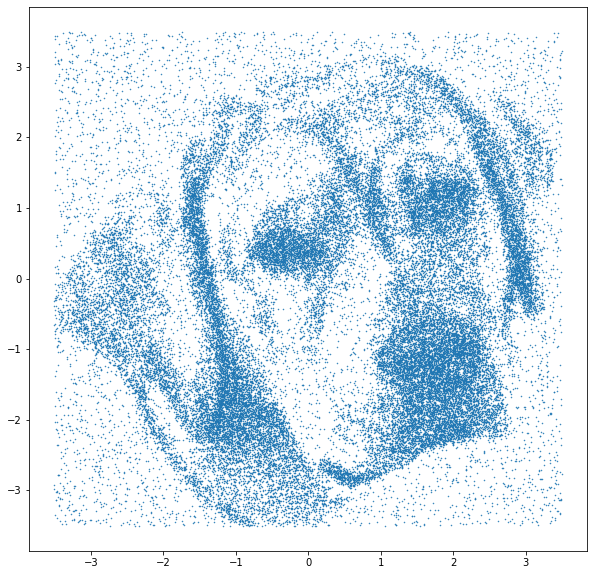

In [12]:
sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
X = sampler.sample(50000)
data = torch.tensor(X, dtype=torch.float32)

plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)

In [13]:
prior = NormalDistribution(2)
target = ImageEnergy(img_energy[::-1].copy(), mean=mean, scale=scale)

Learn transformation with RNVP
-----

In [14]:
batchsize = 250
training_steps = 2000

In [15]:
bg_RNVP = boltzmann_generator_RNVP_MC(prior, target, 5)

trainer = KLTrainer(bg_RNVP, train_likelihood=True, train_energy=False,
                    optim = torch.optim.Adam(bg_RNVP.parameters(), lr=1e-3))

In [16]:
trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: 3.2630	
21	NLL: 2.0838	
41	NLL: 2.0073	
61	NLL: 1.9135	
81	NLL: 1.8156	
101	NLL: 1.7313	
121	NLL: 1.7882	
141	NLL: 1.7415	
161	NLL: 1.7999	
181	NLL: 1.7068	
201	NLL: 1.8420	
221	NLL: 1.6969	
241	NLL: 1.7254	
261	NLL: 1.7441	
281	NLL: 1.7831	
301	NLL: 1.7402	
321	NLL: 1.6983	
341	NLL: 1.6730	
361	NLL: 1.7653	
381	NLL: 1.6413	
401	NLL: 1.7501	
421	NLL: 1.6399	
441	NLL: 1.6804	
461	NLL: 1.6864	
481	NLL: 1.7090	
501	NLL: 1.6224	
521	NLL: 1.7255	
541	NLL: 1.6556	
561	NLL: 1.7534	
581	NLL: 1.7104	
601	NLL: 1.6971	
621	NLL: 1.6130	
641	NLL: 1.7245	
661	NLL: 1.6392	
681	NLL: 1.6901	
701	NLL: 1.7647	
721	NLL: 1.7037	
741	NLL: 1.6360	
761	NLL: 1.6302	
781	NLL: 1.5719	
801	NLL: 1.6535	
821	NLL: 1.8228	
841	NLL: 1.6789	
861	NLL: 1.6580	
881	NLL: 1.6473	
901	NLL: 1.6973	
921	NLL: 1.6666	
941	NLL: 1.7044	
961	NLL: 1.7695	
981	NLL: 1.5961	
1001	NLL: 1.7085	
1021	NLL: 1.7157	
1041	NLL: 1.6871	
1061	NLL: 1.6588	
1081	NLL: 1.7275	
1101	NLL: 1.6519	
1121	NLL: 1.6164	
1141	NLL: 1.7239	
1161	NLL: 1.

Text(0, 0.5, 'NLL')

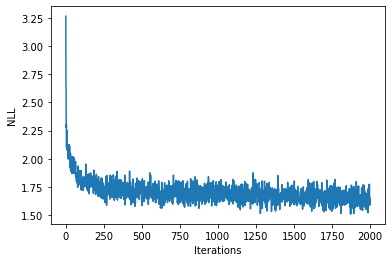

In [17]:
loss_names, x, ys = trainer.losses()
for (loss_name, y) in zip(loss_names, ys):
    plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel(loss_name)

(-3.5, 3.5)

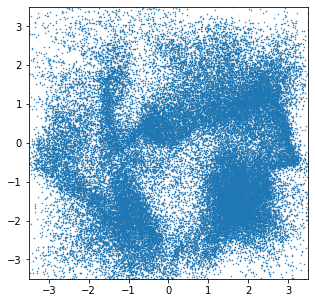

In [18]:
Z = prior.sample(50000)
Y_RNVP, _ = bg_RNVP.flow(Z)
Y_RNVP = Y_RNVP.detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_RNVP[:, 0], Y_RNVP[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [19]:
bg_RNVP_metro = boltzmann_generator_RNVP_MC(prior, target, 5, stochastic=True, nrelax=10, stepsize=0.1)

trainer = KLTrainer(bg_RNVP_metro, train_likelihood=True, train_energy=False,
                    optim = torch.optim.Adam(bg_RNVP_metro.parameters(), lr=1e-3))

In [20]:
trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: 3.6315	
21	NLL: 2.1783	
41	NLL: 2.0148	
61	NLL: 1.9247	
81	NLL: 3.4847	
101	NLL: 1.9271	
121	NLL: 2.2514	
141	NLL: 1.9003	
161	NLL: 1.8713	
181	NLL: 1.8696	
201	NLL: 1.9483	
221	NLL: 1.8905	
241	NLL: 1.9174	
261	NLL: 2.1077	
281	NLL: 1.9558	
301	NLL: 1.9138	
321	NLL: 3.2432	
341	NLL: 2.2403	
361	NLL: 1.8680	
381	NLL: 1.8603	
401	NLL: 1.9169	
421	NLL: 1.9273	
441	NLL: 1.8232	
461	NLL: 1.7678	
481	NLL: 1.8993	
501	NLL: 1.8677	
521	NLL: 1.9842	
541	NLL: 1.7547	
561	NLL: 1.6911	
581	NLL: 1.7330	
601	NLL: 1.7667	
621	NLL: 1.8118	
641	NLL: 1.9188	
661	NLL: 1.8333	
681	NLL: 1.8520	
701	NLL: 1.8386	
721	NLL: 1.7927	
741	NLL: 1.8054	
761	NLL: 1.7965	
781	NLL: 1.8592	
801	NLL: 1.6849	
821	NLL: 1.7183	
841	NLL: 1.8757	
861	NLL: 1.9675	
881	NLL: 1.8186	
901	NLL: 1.9300	
921	NLL: 1.7121	
941	NLL: 1.9565	
961	NLL: 1.8171	
981	NLL: 1.7299	
1001	NLL: 1.8359	
1021	NLL: 1.8407	
1041	NLL: 1.9082	
1061	NLL: 1.8650	
1081	NLL: 1.7856	
1101	NLL: 1.8699	
1121	NLL: 1.7297	
1141	NLL: 1.8555	
1161	NLL: 1.

Text(0, 0.5, 'NLL')

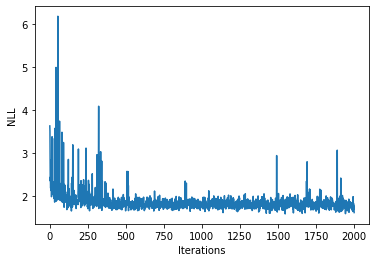

In [21]:
loss_names, x, ys = trainer.losses()
for (loss_name, y) in zip(loss_names, ys):
    plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel(loss_name)
#plt.ylim(0, 2)

(-3.5, 3.5)

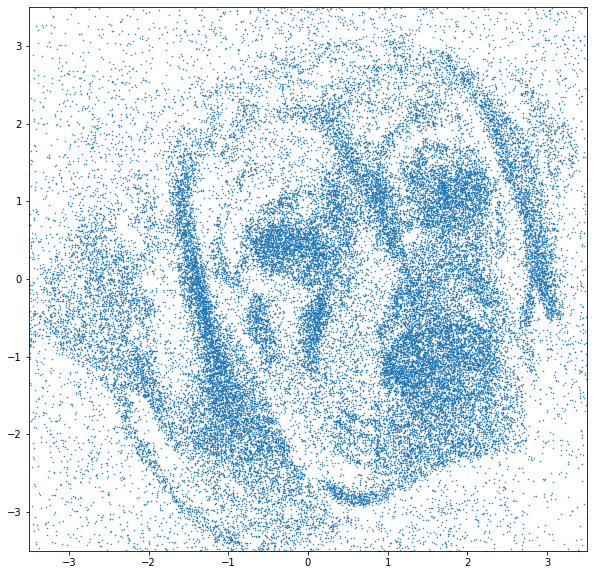

In [22]:
Z = prior.sample(50000)
Y_RNVP_metro, _ = bg_RNVP_metro.flow(Z)
Y_RNVP_metro = Y_RNVP_metro.detach()

plt.figure(figsize=(10, 10))
plt.plot(Y_RNVP_metro[:, 0], Y_RNVP_metro[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

(-3.5, 3.5)

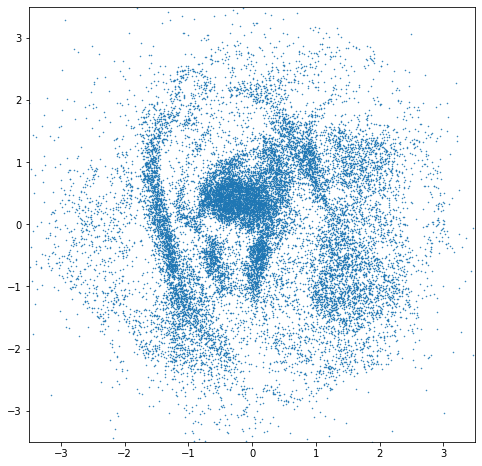

In [23]:
# only MCMC

Z = prior.sample(20000)
mcflow = MetropolisMCFlow(target, nsteps=50, stepsize=0.1)
Y_metro, _ = mcflow(Z)

plt.figure(figsize=(8,8))
plt.plot(Y_metro[:, 0], Y_metro[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [24]:
bg_nsf = boltzmann_generator_NSF_MC(prior, target, 5, tail=tail)

trainer = KLTrainer(bg_nsf, train_likelihood=True, train_energy=False,
                    optim = torch.optim.Adam(bg_nsf.parameters(), lr=1e-3))

In [25]:
trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: 3.0684	
21	NLL: 1.9884	
41	NLL: 1.7520	
61	NLL: 1.6951	
81	NLL: 1.7001	
101	NLL: 1.6816	
121	NLL: 1.6867	
141	NLL: 1.6848	
161	NLL: 1.6287	
181	NLL: 1.5780	
201	NLL: 1.7410	
221	NLL: 1.5938	
241	NLL: 1.5143	
261	NLL: 1.5139	
281	NLL: 1.6382	
301	NLL: 1.5255	
321	NLL: 1.6404	
341	NLL: 1.6167	
361	NLL: 1.5741	
381	NLL: 1.5531	
401	NLL: 1.6779	
421	NLL: 1.5684	
441	NLL: 1.5450	
461	NLL: 1.6653	
481	NLL: 1.6344	
501	NLL: 1.5898	
521	NLL: 1.5775	
541	NLL: 1.4675	
561	NLL: 1.5900	
581	NLL: 1.5211	
601	NLL: 1.5421	
621	NLL: 1.5362	
641	NLL: 1.5591	
661	NLL: 1.6467	
681	NLL: 1.6851	
701	NLL: 1.4905	
721	NLL: 1.6257	
741	NLL: 1.5765	
761	NLL: 1.5746	
781	NLL: 1.5501	
801	NLL: 1.4656	
821	NLL: 1.6827	
841	NLL: 1.6218	
861	NLL: 1.5769	
881	NLL: 1.5111	
901	NLL: 1.6168	
921	NLL: 1.6178	
941	NLL: 1.7065	
961	NLL: 1.5607	
981	NLL: 1.6077	
1001	NLL: 1.5181	
1021	NLL: 1.5321	
1041	NLL: 1.4657	
1061	NLL: 1.4291	
1081	NLL: 1.5550	
1101	NLL: 1.5354	
1121	NLL: 1.4945	
1141	NLL: 1.4864	
1161	NLL: 1.

Text(0, 0.5, 'NLL')

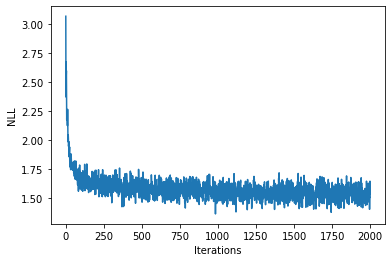

In [26]:
loss_names, x, ys = trainer.losses()
for (loss_name, y) in zip(loss_names, ys):
    plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel(loss_name)
#plt.ylim(0, 2)

(-3.5, 3.5)

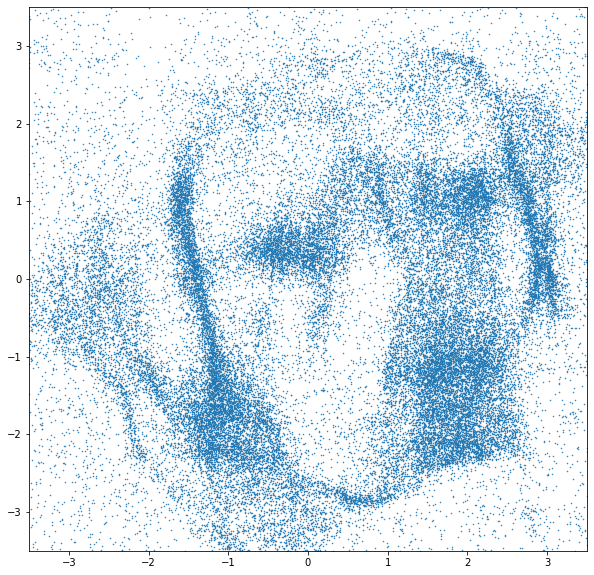

In [27]:
Z = prior.sample(50000)
Y_NSF, _ = bg_nsf.flow(Z)
Y_NSF = Y_NSF.detach()

plt.figure(figsize=(10, 10))
plt.plot(Y_NSF[:, 0], Y_NSF[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [28]:
bg_nsf_metro = boltzmann_generator_NSF_MC(prior, target, 5, tail=tail, stochastic=True, nrelax=10, stepsize=0.1)

trainer = KLTrainer(bg_nsf_metro, train_likelihood=True, train_energy=False,
                    optim = torch.optim.Adam(bg_nsf_metro.parameters(), lr=1e-3))

In [29]:
trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=20)

1	NLL: 2.7955	
21	NLL: 2.5691	
41	NLL: 2.4570	
61	NLL: 2.2315	
81	NLL: 2.3021	
101	NLL: 1.9190	
121	NLL: 2.2421	
141	NLL: 1.9588	
161	NLL: 2.0610	
181	NLL: 1.9065	
201	NLL: 1.9016	
221	NLL: 1.9435	
241	NLL: 2.1532	
261	NLL: 1.8978	
281	NLL: 2.0517	
301	NLL: 1.9861	
321	NLL: 2.0420	
341	NLL: 2.0796	
361	NLL: 1.8653	
381	NLL: 1.7517	
401	NLL: 2.0847	
421	NLL: 2.0683	
441	NLL: 1.9884	
461	NLL: 1.8775	
481	NLL: 2.1843	
501	NLL: 1.8359	
521	NLL: 2.0262	
541	NLL: 1.9837	
561	NLL: 2.0007	
581	NLL: 1.8153	
601	NLL: 2.1475	
621	NLL: 2.1444	
641	NLL: 1.9883	
661	NLL: 2.0620	
681	NLL: 2.0072	
701	NLL: 2.1352	
721	NLL: 1.9344	
741	NLL: 2.1374	
761	NLL: 1.9520	
781	NLL: 1.9941	
801	NLL: 1.9063	
821	NLL: 2.0288	
841	NLL: 1.9728	
861	NLL: 1.9781	
881	NLL: 2.0566	
901	NLL: 1.9987	
921	NLL: 1.8917	
941	NLL: 2.1812	
961	NLL: 1.9189	
981	NLL: 1.8955	
1001	NLL: 1.9732	
1021	NLL: 1.9210	
1041	NLL: 1.9824	
1061	NLL: 1.9285	
1081	NLL: 2.2657	
1101	NLL: 1.9516	
1121	NLL: 2.1146	
1141	NLL: 2.0066	
1161	NLL: 1.

Text(0, 0.5, 'NLL')

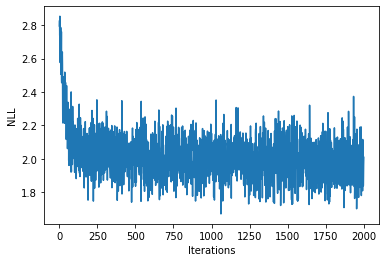

In [30]:
loss_names, x, ys = trainer.losses()
for (loss_name, y) in zip(loss_names, ys):
    plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel(loss_name)
#plt.ylim(0, 2)

(-3.5, 3.5)

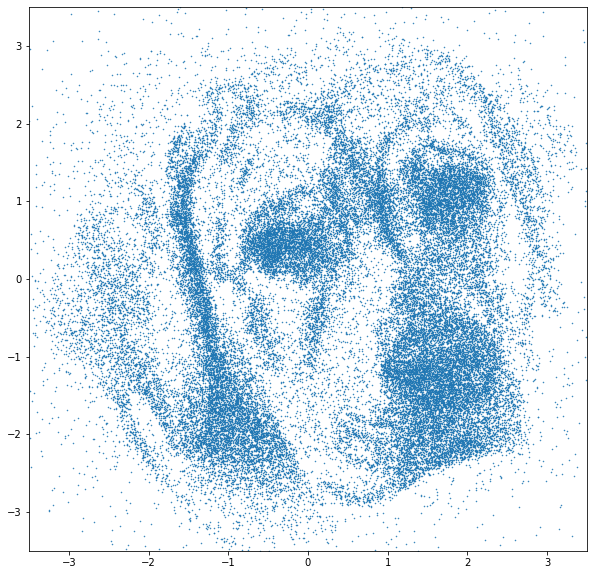

In [31]:
Z = prior.sample(50000)
Y_NSF_metro, _ = bg_nsf_metro.flow(Z)
Y_NSF_metro = Y_NSF_metro.detach()

plt.figure(figsize=(10, 10))
plt.plot(Y_NSF_metro[:, 0], Y_NSF_metro[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

result
---

In [32]:
# sample more dense

with torch.no_grad():
    nsamples = 500000

    sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
    X = sampler.sample(nsamples)

    Z = prior.sample(nsamples)
    Y_RNVP, _ = bg_RNVP.flow(Z)
    Y_RNVP = Y_RNVP.detach()

    Y_RNVP_metro, _ = bg_RNVP_metro.flow(Z)
    Y_RNVP_metro = Y_RNVP_metro.detach()

    mcflow = MetropolisMCFlow(target, nsteps=50, stepsize=0.02)
    Y_metro, _ = mcflow(Z)
    Y_metro = Y_metro.detach()

    Y_NSF, _ = bg_nsf.flow(Z)
    Y_NSF = Y_NSF.detach()

    Y_NSF_metro, _ = bg_nsf_metro.flow(Z)
    Y_NSF_metro = Y_NSF_metro.detach()    

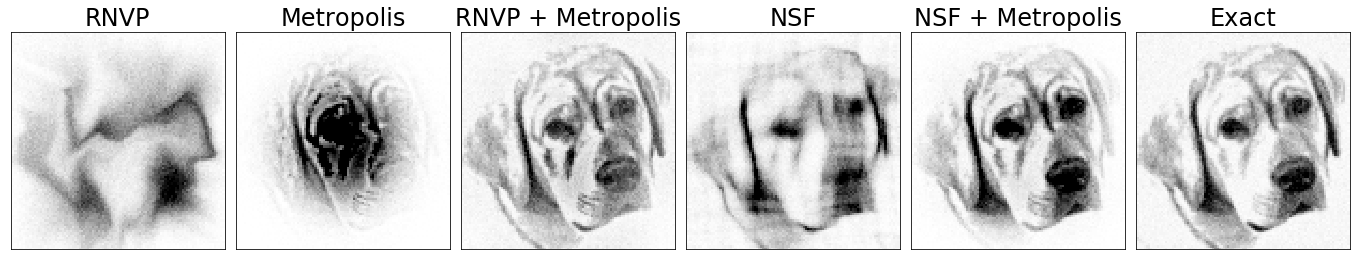

In [33]:
nbins = 100
vmax = 250
xrange=(-3.5, 3.5)
yrange=(-3.5, 3.5)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24, 4))
fig.subplots_adjust(wspace=0.05)

axes[0].set_title('RNVP', fontsize=24)
axes[1].set_title('Metropolis', fontsize=24)
axes[2].set_title('RNVP + Metropolis', fontsize=24)
axes[3].set_title('NSF', fontsize=24)
axes[4].set_title('NSF + Metropolis', fontsize=24)
axes[5].set_title('Exact', fontsize=24)
axes[0].hist2d(Y_RNVP.numpy()[:, 0], Y_RNVP.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[1].hist2d(Y_metro.numpy()[:, 0], Y_metro.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[2].hist2d(Y_RNVP_metro.numpy()[:, 0], Y_RNVP_metro.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[3].hist2d(Y_NSF.numpy()[:, 0], Y_NSF.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[4].hist2d(Y_NSF_metro.numpy()[:, 0], Y_NSF_metro.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[5].hist2d(X[:, 0], X[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
for i in range(6):
    axes[i].set_xlim(xrange[0], xrange[1])
    axes[i].set_ylim(yrange[0], yrange[1])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [34]:
#fig.savefig('../figs/images/images_dog_comparison.pdf')

Quantify representative power
----

In [35]:
nbins = 50
hist_X, xrange, yrange = target.density(nbins)

In [36]:
depths = [1, 2, 3, 4, 6, 8]
batchsize = 250
training_steps = 2000
nsamples = 500000

In [37]:
hists_RNVP_repr = []

for depth in depths:
    print(depth)
    bg = boltzmann_generator_RNVP_MC(prior, target, depth)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_RNVP_repr.append(hist_Y_)   

1
2
3
4
6
8


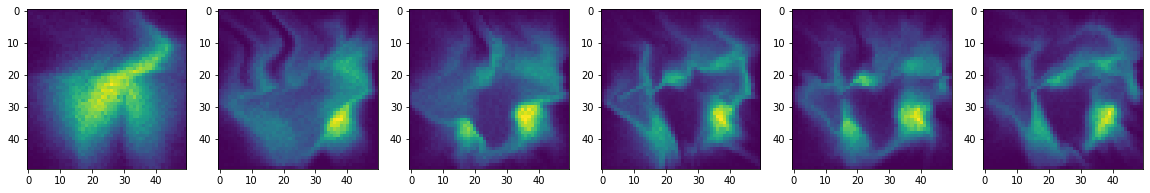

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 6))
for ax, hist in zip(axes, hists_RNVP_repr):
    ax.imshow(hist.T[::-1]);

In [39]:
kls_RNVP = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_RNVP_repr]

In [40]:
hists_RNVP_metro_repr = []

for depth in depths:
    print(depth)
    bg = boltzmann_generator_RNVP_MC(prior, target, depth, stochastic=True, nrelax=10, stepsize=0.1)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_RNVP_metro_repr.append(hist_Y_)   

1
2
3
4
6
8


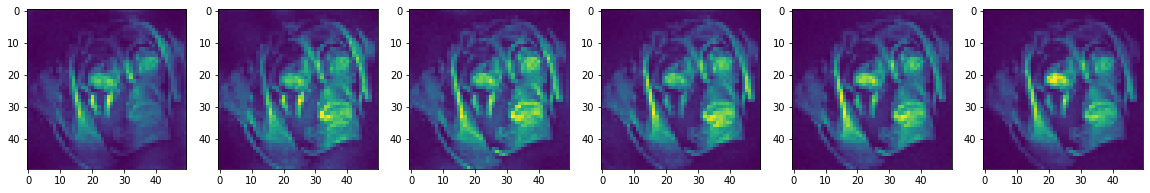

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 6))
for ax, hist in zip(axes, hists_RNVP_metro_repr):
    ax.imshow(hist.T[::-1]);

In [42]:
kls_RNVP_metro = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_RNVP_metro_repr]

In [43]:
hists_NSF_repr = []

for depth in depths:
    print(depth)
    bg = boltzmann_generator_NSF_MC(prior, target, depth, tail=tail)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_NSF_repr.append(hist_Y_)   

1
2
3
4
6
8


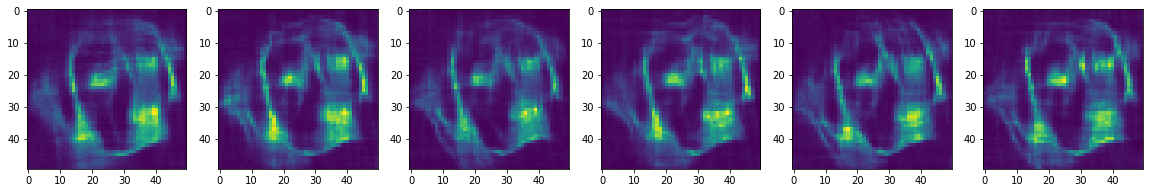

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 6))
for ax, hist in zip(axes, hists_NSF_repr):
    ax.imshow(hist.T[::-1]);

In [45]:
kls_NSF = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_NSF_repr]

In [46]:
hists_NSF_metro_repr = []

for depth in depths:
    print(depth)
    bg = boltzmann_generator_NSF_MC(prior, target, depth, tail=tail, stochastic=True, nrelax=10, stepsize=0.1)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_NSF_metro_repr.append(hist_Y_)   

1
2
3
4
6
8


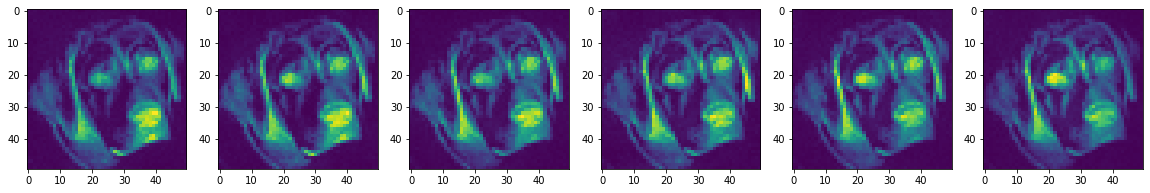

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 6))
for ax, hist in zip(axes, hists_NSF_metro_repr):
    ax.imshow(hist.T[::-1]);

In [48]:
kls_NSF_metro = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_NSF_metro_repr]

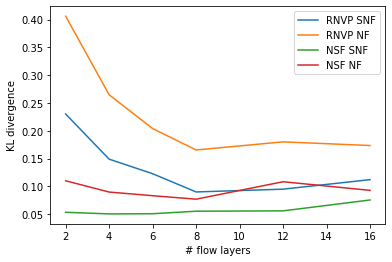

In [49]:
nlayers = 2*np.array(depths)
plt.plot(nlayers, kls_RNVP_metro, label="RNVP SNF")
plt.plot(nlayers, kls_RNVP, label="RNVP NF")
plt.plot(nlayers, kls_NSF_metro, label="NSF SNF")
plt.plot(nlayers, kls_NSF, label="NSF NF")
plt.xlabel('# flow layers')
plt.ylabel('KL divergence')
plt.legend()

Sampling efficiency
---

In [50]:
training_steps = 2000
hists_RNVP_sample = []
depth = 5
steps_relax = [0, 1, 2, 5, 10, 20, 50]

for nrelax in steps_relax:
    print(nrelax)
    bg = boltzmann_generator_RNVP_MC(prior, target, depth, stochastic=True, nrelax=nrelax, stepsize=0.1)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_RNVP_sample.append(hist_Y_)    

0
1
2
5
10
20
50


In [51]:
KL_RNVP_sample = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_RNVP_sample]

In [52]:
steplengths = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
# only MCMC

hists_metro_sample = []
for nsteps in steplengths:
    print(nsteps)
    mcflow = MetropolisMCFlow(target, nsteps=nsteps, stepsize=0.1)
    Z = prior.sample(nsamples)
    Y_, _ = mcflow(Z)

    hist_Y_, _, _ = np.histogram2d(Y_.numpy()[:, 0], Y_.numpy()[:, 1], 
                                   bins=nbins, range=[xrange, yrange])
    hist_Y_ /= hist_Y_.sum()
    hists_metro_sample.append(hist_Y_)

5
10
20
50
100
200
500
1000
2000
5000


In [53]:
KL_metro_sample = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_metro_sample]

In [54]:
training_steps = 2000
hists_NSF_sample = []
depth = 5
steps_relax = [0, 1, 2, 5, 10, 20, 50]

for nrelax in steps_relax:
    print(nrelax)
    bg = boltzmann_generator_NSF_MC(prior, target, depth, tail=tail, stochastic=True, nrelax=nrelax, stepsize=0.1)

    trainer = KLTrainer(bg, train_likelihood=True, train_energy=False,
                        optim = torch.optim.Adam(bg.parameters(), lr=1e-3))
    
    trainer.train(training_steps, data=data, batchsize=batchsize, w_likelihood=1, w_energy=0, n_print=0)
    
    # sample 
    hist_Y_ = sample_bg_histogram(bg, nsamples=nsamples, nbins=nbins, xrange=xrange, yrange=yrange)
    hists_NSF_sample.append(hist_Y_)    

0
1
2
5
10
20
50


In [55]:
KL_NSF_sample = [kldiv(hist_X, hist, reg_X=1e-10, reg_Y=1e-10) for hist in hists_NSF_sample]

In [56]:
steplengths

[5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

(0, 1)

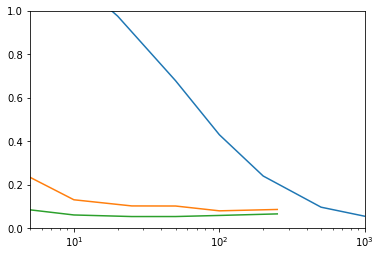

In [57]:
plt.plot(steplengths, KL_metro_sample)
plt.plot(5*np.array(steps_relax), np.array(KL_RNVP_sample))
plt.plot(5*np.array(steps_relax), np.array(KL_NSF_sample))
plt.semilogx()
plt.xlim(5, 1e3)
plt.ylim(0, 1)